In [7]:
import numpy as np
import scipy.linalg as spl
from numpy.random import uniform

class TreeNode:
    def __init__(self, isLeaf: bool):
        self.isLeaf = isLeaf
        self.size = None
        self.rank = 0
        self.singular_values = 0
        self.U: np.ndarray = None
        self.V: np.ndarray = None
        self.left_upper: TreeNode = None
        self.right_upper: TreeNode = None
        self.left_lower: TreeNode = None
        self.right_lower: TreeNode = None



def truncatedSVD(A, r):
    rank = min(r, A.shape[0], A.shape[1])
    u, s, v = spl.svd(A)
    u = u[:, 0:rank]
    v = v[0:rank, :]
    s = s[0:rank]
    return u, s, v


def consist_of_zeros(A):
    return np.all(A==0)

def compress_matrix(A: np.ndarray, first_row: int, last_row: int, first_col: int, last_col: int, r):
    v = TreeNode(True)
    v.size = (first_row, last_row, first_col, last_col)
    U, D, V = truncatedSVD(A, r + 1)
    if consist_of_zeros(A):
        v.rank = 0
    else:
        v.rank = r
        v.singular_values = D[0 : r]
        v.U = U[:, 0 : r]
        v.V =  V[0 : r, :]
    return v


def create_tree(A: np.ndarray, first_row: int, last_row: int, first_col: int, last_col: int, r: int,
                eps: float) -> TreeNode:
    new_A = A[first_row: last_row, first_col: last_col]
    U, D, V = truncatedSVD(new_A, r + 1)
    if r + 1 > D.shape[0] or D[r] < eps:
        if D.shape[0] <= 2:
            v = compress_matrix(new_A, first_row, last_row, first_col, last_col, 1)
        else:
            v = compress_matrix(new_A, first_row, last_row, first_col, last_col, r)
    else:
        v = TreeNode(False)
        middle_row = (first_row + last_row) // 2
        middle_col = (first_col + last_col) // 2
        v.left_upper = create_tree(A, first_row, middle_row, first_col, middle_col, r, eps)
        v.right_upper = create_tree(A, first_row, middle_row, middle_col, last_col, r, eps)
        v.left_lower = create_tree(A, middle_row, last_row, first_col, middle_col, r, eps)
        v.right_lower = create_tree(A, middle_row, last_row, middle_col, last_col, r, eps)
    return v



def decompose_tree(root: TreeNode) -> np.ndarray:
    if root.isLeaf:
        if root.rank == 0:
            row_size = root.size[1] - root.size[0]
            col_size = root.size[3] - root.size[2]
            return np.zeros((row_size, col_size))
        else:
            return root.U @ (root.singular_values * np.identity(len(root.singular_values))) @ root.V
    else:
        M11 = decompose_tree(root.left_upper)
        M21 = decompose_tree(root.left_lower)
        M12 = decompose_tree(root.right_upper)
        M22 = decompose_tree(root.right_lower)
        return np.concatenate(
        [np.concatenate([M11, M12], axis=1),
         np.concatenate([M21, M22], axis=1)],
        axis=0,)

def mse(A, B):
    return np.sum(np.square(A - B))


def generate_matrix(ncols: int, nrows: int, propability=1) -> np.ndarray:
    M = np.random.randint(1, 9, size=(nrows, ncols))
    R = np.random.uniform(size=(nrows, ncols))
    R = R <= propability
    return np.where(R, M, 0)




In [8]:
import matplotlib.pyplot as plt

def tree_to_draw_matrix(root: TreeNode) -> np.ndarray:
    if root.isLeaf:
        row_size = root.size[1] - root.size[0]
        col_size = root.size[3] - root.size[2]
        if root.rank == 0:
            return np.zeros((row_size, col_size))
        else:
            M = np.zeros((row_size, col_size))
            for i in range(root.rank):
                for row in range(row_size):
                    M[row, i] = 1
                for col in range(col_size):
                    M[i, col] = 1
            return M

    else:
        M11 = tree_to_draw_matrix(root.left_upper)
        M21 = tree_to_draw_matrix(root.left_lower)
        M12 = tree_to_draw_matrix(root.right_upper)
        M22 = tree_to_draw_matrix(root.right_lower)
        return np.concatenate(
            [np.concatenate([M11, M12], axis=1),
             np.concatenate([M21, M22], axis=1)],
            axis=0,)

def draw_tree(root: TreeNode):
    M = tree_to_draw_matrix(root)
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    where_0 = np.where(M == 0)
    where_1 = np.where(M == 1)
    M[where_0] = 1
    M[where_1] = 0
    plt.imshow(M, cmap='gray')





In [9]:
import random
def generate_with_prob(prob):
    if random.random() < prob:
        return uniform(0, 1)
    else:
        return 0

def gen_matrix(n, prob):
    return np.array([[generate_with_prob(prob) for _ in range(n)] for _ in range(n)])


In [84]:
matrix = gen_matrix(64, 0.1)
node = create_tree(matrix, 0, matrix.shape[0], 0, matrix.shape[1], 1,0.001)
b = decompose_tree(node)
print(mse(matrix, b))
mat = np.array([1, 2, 3])
print(mat)
print(mat.reshape((len(mat), 1)))

1.3628118081640804e-30
[1 2 3]
[[1]
 [2]
 [3]]


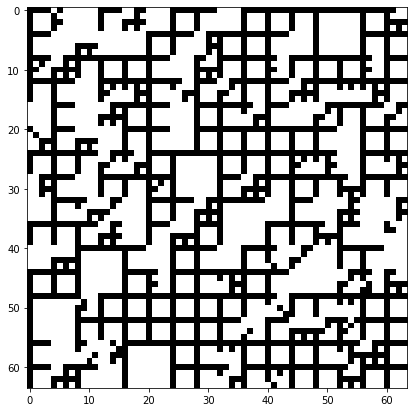

In [49]:
draw_tree(node)

```python
def create_tree(A, first_row, last_row, first_col, last_col, r, eps):
    U, D, V = SVD(A, r + 1)
    if r + 1 > D.shape[0] or D[r] < eps:
        v = compress_matrix(new_A, first_row, last_row, first_col, last_col, r)
    else:
        v = TreeNode()
        middle_row = (first_row + last_row) // 2
        middle_col = (first_col + last_col) // 2
        v.left_upper = create_tree(A, first_row, middle_row, first_col, middle_col, r, eps)
        v.right_upper = create_tree(A, first_row, middle_row, middle_col, last_col, r, eps)
        v.left_lower = create_tree(A, middle_row, last_row, first_col, middle_col, r, eps)
        v.right_lower = create_tree(A, middle_row, last_row, middle_col, last_col, r, eps)
    return v

 def compress_matrix(A, first_row, last_row, first_col, last_col, r):
    v = TreeNode()
    v.size = (first_row, last_row, first_col, last_col)
    U, D, V = SVD(A, r + 1)
    if consist_of_zeros(A):
        v.rank = 0
    else:
        v.rank = r
        v.singular_values = D
        v.U = U
        v.V = V
    return v
```

```python
def decompose_tree(root):
    if root.isLeaf:
        if root.rank == 0:
            row_size = root.size[1] - root.size[0]
            col_size = root.size[3] - root.size[2]
            return zeros((row_size, col_size))
        else:
            return root.U @ (root.singular_values * np.identity(len(root.singular_values))) @ root.V
    else:
        M11 = decompose_tree(root.left_upper)
        M21 = decompose_tree(root.left_lower)
        M12 = decompose_tree(root.right_upper)
        M22 = decompose_tree(root.right_lower)
        return np.concatenate(
        [np.concatenate([M11, M12], axis=1),
         np.concatenate([M21, M22], axis=1)],
        axis=0,)
```

In [75]:
from numpy.random import uniform
from timeit import timeit

def count_operations_and_time(size_x):
    matrix = gen_matrix(size_x, 0.5)
    time = timeit(lambda: create_tree(matrix, 0, matrix.shape[0], 0, matrix.shape[1],5, 0.01), number=1)
    return time

matrix_sizes = [2 ** i for i in range(2, 10)]
times = []

for matrix_size in matrix_sizes:
    time = count_operations_and_time(matrix_size)
    times.append(time)
    print(time)

0.0002328579998902569
0.0002963000001727778
0.0012721190000775096
0.004847254000196699
0.021005211000101554
0.0790195570002652
0.31905681999978697
1.6113455459999386


/tmp/ipykernel_6143/4168042763.py:13: RuntimeWarning: invalid value encountered in power
  return a * x**b


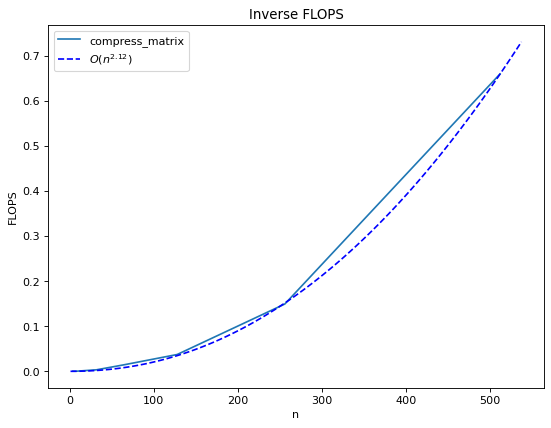

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

matrix_sizes = np.array(matrix_sizes)
times = np.array(times)
plt.plot(matrix_sizes, times, label="compress_matrix")

def f(x, a, b):
    return a * x**b

x = matrix_sizes.astype(np.float64)
y = times.astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y)
x = np.linspace(*plt.xlim(), 100)
plt.plot(x, f(x, *popt), 'b--', label=f'$O(n^{{{popt[1]:.2f}}})$')

plt.legend()
plt.title('Inverse FLOPS')
plt.xlabel('n')
plt.ylabel('FLOPS')
plt.show()

/tmp/ipykernel_6143/4168042763.py:13: RuntimeWarning: invalid value encountered in power
  return a * x**b


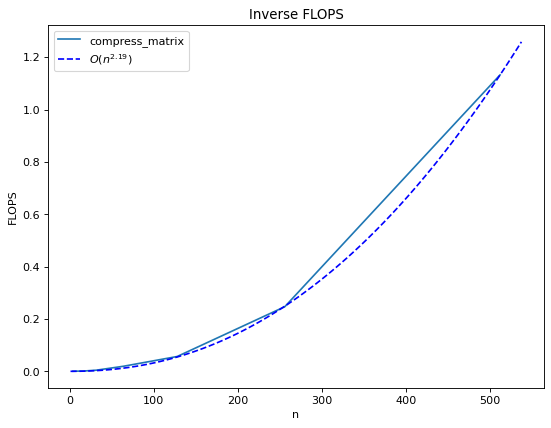

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

matrix_sizes = np.array(matrix_sizes)
times = np.array(times)
plt.plot(matrix_sizes, times, label="compress_matrix")

def f(x, a, b):
    return a * x**b

x = matrix_sizes.astype(np.float64)
y = times.astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y)
x = np.linspace(*plt.xlim(), 100)
plt.plot(x, f(x, *popt), 'b--', label=f'$O(n^{{{popt[1]:.2f}}})$')

plt.legend()
plt.title('Inverse FLOPS')
plt.xlabel('n')
plt.ylabel('FLOPS')
plt.show()

/tmp/ipykernel_6143/4168042763.py:13: RuntimeWarning: invalid value encountered in power
  return a * x**b


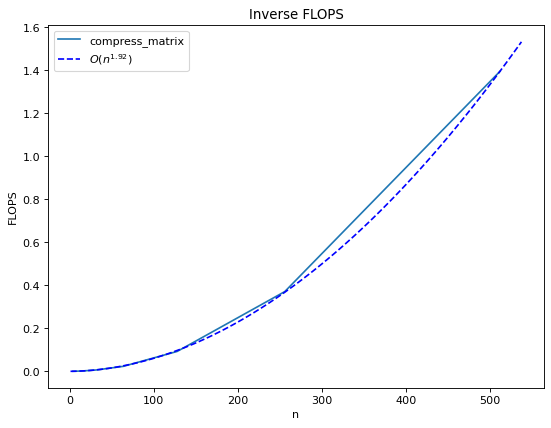

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

matrix_sizes = np.array(matrix_sizes)
times = np.array(times)
plt.plot(matrix_sizes, times, label="compress_matrix")

def f(x, a, b):
    return a * x**b

x = matrix_sizes.astype(np.float64)
y = times.astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y)
x = np.linspace(*plt.xlim(), 100)
plt.plot(x, f(x, *popt), 'b--', label=f'$O(n^{{{popt[1]:.2f}}})$')

plt.legend()
plt.title('Inverse FLOPS')
plt.xlabel('n')
plt.ylabel('FLOPS')
plt.show()

/tmp/ipykernel_6143/4168042763.py:13: RuntimeWarning: invalid value encountered in power
  return a * x**b


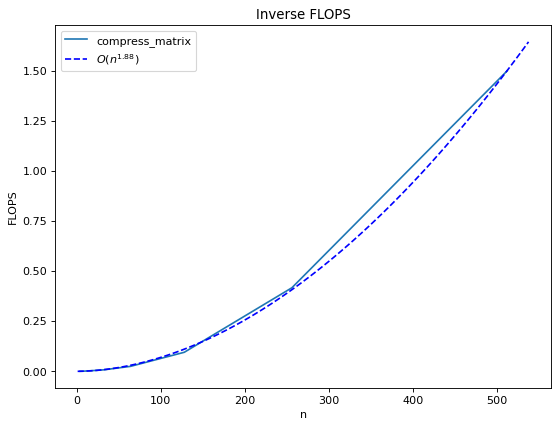

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

matrix_sizes = np.array(matrix_sizes)
times = np.array(times)
plt.plot(matrix_sizes, times, label="compress_matrix")

def f(x, a, b):
    return a * x**b

x = matrix_sizes.astype(np.float64)
y = times.astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y)
x = np.linspace(*plt.xlim(), 100)
plt.plot(x, f(x, *popt), 'b--', label=f'$O(n^{{{popt[1]:.2f}}})$')

plt.legend()
plt.title('Inverse FLOPS')
plt.xlabel('n')
plt.ylabel('FLOPS')
plt.show()

/tmp/ipykernel_6143/4168042763.py:13: RuntimeWarning: invalid value encountered in power
  return a * x**b


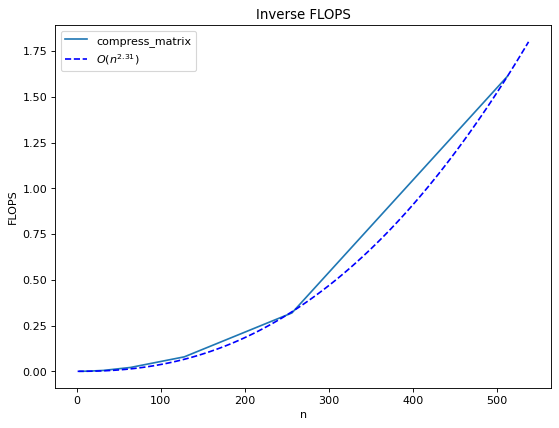

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

matrix_sizes = np.array(matrix_sizes)
times = np.array(times)
plt.plot(matrix_sizes, times, label="compress_matrix")

def f(x, a, b):
    return a * x**b

x = matrix_sizes.astype(np.float64)
y = times.astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y)
x = np.linspace(*plt.xlim(), 100)
plt.plot(x, f(x, *popt), 'b--', label=f'$O(n^{{{popt[1]:.2f}}})$')

plt.legend()
plt.title('Inverse FLOPS')
plt.xlabel('n')
plt.ylabel('FLOPS')
plt.show()